[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NiCALab-IMAL/coadpative_BOTDA/blob/main/H3_BadTraining.ipynb)

In [ ]:
!pip3 install mne
!pip install POT
!git clone https://github.com/vpeterson/otda-mibci.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 7.7 MB/s eta 0:00:00
Cloning into 'otda-mibci'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 270 (delta 82), reused 87 (delta 36), pack-reused 120
Receiving objects: 100% (270/270), 82.39 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [ ]:
import numpy as np
import sys
sys.path.insert(1, 'otda-mibci')
import mne
import os.path as op
import os
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'C:/Users/Visitante/Documents/otda-mibci-master/otda-mibci-master')
from MIOTDAfunctions import*
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import ot.plot
from tabulate import tabulate


In [ ]:
def Backward_GroupLasso_Transport(Gtr_daot, Ytr_daot, regu_, Gtr, Ytr, Gval, Yval, Gte, lda, metric):
      
    botda = ot.da.SinkhornL1l2Transport(metric=metric, reg_e=regu_[0], reg_cl=regu_[1])
    # learn params of transport
    botda.fit(Xs=Gval, ys=Yval, Xt=Gtr_daot)
    botda_matrix = botda.coupling_
    #transport testing samples
    transp_Xt_backward=botda.transform(Xs=Gte)
    
    # Compute accuracy without retraining    
    yt_predict = lda.predict(transp_Xt_backward) 
    
    return yt_predict, transp_Xt_backward, botda_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os.path as op
data_path = op.join('/content/drive/MyDrive/Proyecto_coadaptiveBCI/Simulaciones/simulated data/MI vs rest')

# Training on Session with no discriminabe features

Computing rank from data with rank=None
    Using tolerance 0.00013 (2.2e-16 eps * 41 dim * 1.5e+10  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 41 data channels with 0 projectors
Reducing data rank from 41 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00012 (2.2e-16 eps * 41 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 41 data channels with 0 projectors
Reducing data rank from 41 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 41 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 41 data channels with 0 projectors
Reducing data rank from 41 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 41 dim * 1.6e+10  max singular value)


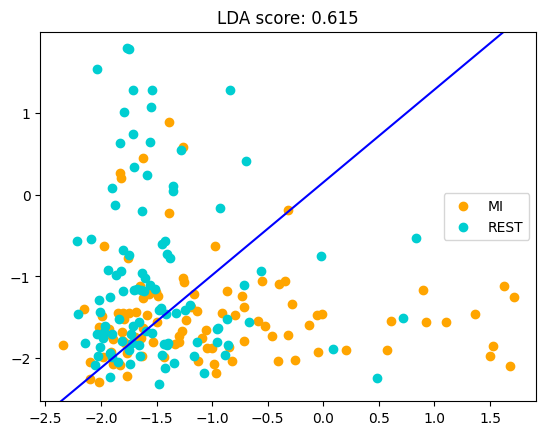

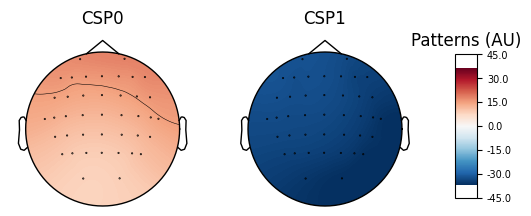

In [ ]:
Data_S1 = op.join(data_path, 'session7_epochs_epo.fif')
epochs_S1 = mne.read_epochs(Data_S1, preload=True, verbose=False)
epochs_S1_array = epochs_S1.get_data()  # Epoched data as a numpy array

# %% Training - Learn CSP+LDA from source data
Xtr = epochs_S1_array.copy()
Ytr = epochs_S1.events[:,2].copy()
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
#learn csp filters
Gtr = csp.fit_transform(Xtr, Ytr)
#learn lda
lda = LinearDiscriminantAnalysis()
lda.fit(Gtr,Ytr)
lda.score(Gtr,Ytr)

#Plot first 2 features
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("LDA score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)
plt.show()

fig = csp.plot_patterns(epochs_S1.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

# TEST on session 6 (ERD =0.25)

/usr/local/lib/python3.10/dist-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.10/dist-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.10/dist-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/usr/local/lib/python3.10/dist-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `re

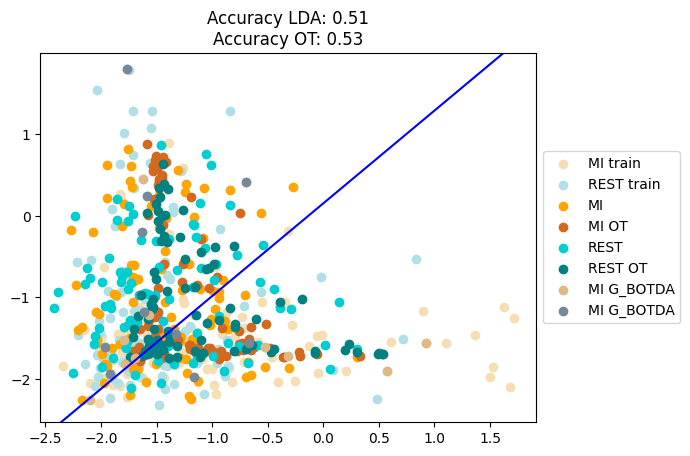

In [ ]:
#%% OTDA parameters
rango_cl=[0.1, 1, 10]
rango_e=[0.1, 1, 10] 
metric = 'sqeuclidean'
outerkfold = 20
innerkfold = None
M=20
norm=None
eps = 1e+6

acc_lda = []
acc_OT = []
Data_test = op.join(data_path, 'session6_epochs_epo.fif')  
epochs_test = mne.read_epochs(Data_test, preload=True, verbose=False)
epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array

#split val and test data 
Xte = epochs_test_array[20:].copy()  # Epoched data as a numpy array
Yte = epochs_test.events[20:,2].copy()
# use the first 20 samples for validation
Xval = epochs_test_array[:20].copy()  # Epoched data as a numpy array
Yval = epochs_test.events[:20,2].copy()

# extract features
Gte=csp.transform(Xte)
Gval=csp.transform(Xval)

y_predict_lda = lda.predict(Gte)
acc_lda.append(accuracy_score(Yte,y_predict_lda))

#  OT
y_predict_ot = []
Transp = []

# Use the first 20 trials as the validation set
Xval=Xte[0:20]
Yval=Yte[0:20]

##
Gval=csp.transform(Xval)

# select source subset
G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)

#  For each sample, make the data adaptation
for re in range(1,len(Yte)+1):
    
    #testing trial
    Xte_ot=Xte[(re-1):(re)]
    Yte_ot=Yte[(re-1):(re)]
    
    Xval=np.vstack((Xval, Xte_ot))
    Yval=np.hstack((Yval, Yte_ot))
    
    #csp estimation
    Gval=csp.transform(Xval)
    Gte_ot=csp.transform(Xte_ot)
  
    yt_pred, transp_Xt_backward, botda_matrix = Backward_GroupLasso_Transport(G_BOTDAl1l2_, Y_BOTDAl1l2_, regu_BOTDAl1l2_, Gtr, Ytr, Gval, Yval, Gte_ot, lda, metric)
    y_predict_ot.append(yt_pred)
    #save transported data
    Transp.append(transp_Xt_backward)
  
Gte_ot=np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

acc_OT.append(accuracy_score(Yte,y_predict_ot))

#Plot first 2 features
ft = Gte[:,0:2]
ft_ot = Gte_ot[:,0:2]

outernMI = np.argsort(ft[Yte==1, 0])[len(ft[Yte==1, 0])-10:]
outernR = np.argsort(ft[Yte==2, 0])[0:10]

x = np.linspace(-1,3,500)
y = np.linspace(2,8,500)
X,Y = np.meshgrid(x,y)
pos = np.array([X.flatten(),Y.flatten()]).T
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='wheat', label='MI train')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='powderblue', label='REST train')   
axs.scatter(ft[Yte==1, 0], ft[Yte==1, 1], c='orange', label='MI')   
axs.scatter(ft_ot[Yte==1, 0], ft_ot[Yte==1, 1], c='chocolate', label='MI OT')    
axs.scatter(ft[Yte==2, 0], ft[Yte==2, 1], c='darkturquoise', label='REST') 
axs.scatter(ft_ot[Yte==2, 0], ft_ot[Yte==2, 1], c='teal', label='REST OT')
# i will plot the subset where the transport is learned
axs.scatter(G_BOTDAl1l2_[Y_BOTDAl1l2_==1, 0], G_BOTDAl1l2_[Y_BOTDAl1l2_==1, 1], c='burlywood', label='MI G_BOTDA')
axs.scatter(G_BOTDAl1l2_[Y_BOTDAl1l2_==2, 0], G_BOTDAl1l2_[Y_BOTDAl1l2_==2, 1], c='lightslategray', label='MI G_BOTDA')
  
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)
#plt.plot([ft[Yte==1, 0][outernMI],ft_ot[Yte==1, 0][outernMI]], [ft[Yte==1, 1][outernMI], ft_ot[Yte==1, 1][outernMI]],'k-', alpha = 0.3)  
#plt.plot([ft[Yte==2, 0][outernR],ft_ot[Yte==2, 0][outernR]], [ft[Yte==2, 1][outernR], ft_ot[Yte==2, 1][outernR]],'k-', alpha = 0.3)

axs.set_title('Accuracy LDA: ' + str(acc_lda)[1:5] + 
              '\nAccuracy OT: ' + str(acc_OT)[1:5])    
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
plt.show()